# Probabilistic Programming and Bayesian Methods for Hackers

http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

## Chap 2: A little more on PyMC3

### At a glance

- ***PyMC3***: variables (stochastic vs. deterministic).
- ***Theano***: just a glimpse of what it is, computational graph.
- ***Distributions***: binomial distribution, normal distribution.
- ***A simple process*** of modeling a problem. What questions should be asked?
- ***A/B testing***: the author ultimately came to a conclusion that Bayesian analysis is more natural and could fit the case in which the observations of A and B are of different sample size.
- ***Assess model***: not mentioned much. A plausible way is to compare the *observed data* and the *data simulated by the model*.
- ***Misc***
    - When using a model, should take into account *how wide the posterior distribution is*. In the "space shuttle disaster" example, the CI (credible interval) spreads out within the region 60-65 temperatures, giving us the insight that more tests should be performed with this range.

### Distributions

#### Binomial distribution
- Discrete variables
- Short notation: $X \sim Bin(N, p)$
- Mass distribution: 
$$f(x\;|\;N) = {N \choose x} p^x (1-p)^{N-x}$$
- Properties:
    - If $X_1, X_2, ..., X_N \sim Ber(p)$, then $Z = X_1 + X_2 + ... + X_N \sim Bin(N, p)$

#### Normal distribution
- Continuous variables
- Density distribution: 
$$f(x\;|\;\mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp\left( -\frac{\tau}{2} (x-\mu)^2 \right)$$
where $\tau = \frac{1}{\sigma^2}$
- Properties:
    - $E[X\;|\;\mu, \tau] = \mu$
    - $Var(X\;|\;\mu, \tau) = \frac{1}{\tau} = \sigma^2$


### Example: Cheating among students

We want to know the frequency of students cheating during an exam. This algorithm below is designed to guarantee the confidentiality of students' answers (so that they feel safe enough to give honest responses). In other words, given an answer, we could not infer that he/she was cheating or not.

#### Privacy algorithm

- Flip the coin twice. Don't tell the interview which side appears.
- If the first flip is HEAD, student should answer honestly.
- Otherwise, if the second toss is HEAD, student answers *"Yes, I did cheat"*.
- Otherwise (the second one turns TAIL), student gives the answer *"No, I didn't"*.

In this way, the surveyor *has no idea whether the student is lying or not*. This is achieved by the **randomness** of the algorithm.

P/s: this algorithm is proposed by the author, not a standard algorithm :). Other approaches could be adopted.

**Representation**

- $p$: frequency of cheating.
- $C_1$: rv., denotes which side appears in the 1st flip (1 if HEAD, otherwise 0)
- $C_2$: rv., denotes which side appears in the 2nd flip (1 if HEAD, otherwise 0)
- $T$: rv., denoting the honest answer when the 1st flip is HEAD, takes 1 if he/she says _"yes"_, otherwise 0.

$\rightarrow$ the final outcome which the interview receives: $X = C_1*T + (1-C_1)*C_2$

**Distributions used for each random variable:**
- $p \sim Uniform(0, 1)$
- $C_1 \sim Ber(0.5)$ $\leftarrow$ Assume $Pr(HEAD) = 0.5$
- $C_2 \sim Ber(0.5)$ $\leftarrow$ Assume $Pr(HEAD) = 0.5$
- $T \sim Ber(p)$

In [1]:
import pymc3 as pm
import theano.tensor as tt

N = 100
with pm.Model() as model:
    p = pm.Uniform('freq_cheating', 0, 1) # Unknown
    true_answers = pm.Bernoulli('truths', p, shape=N, testval=np.random.binomial(1, 0.5, N))
    first_flips = pm.Bernoulli('first_flips', 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))
    second_flips = pm.Bernoulli("second_flips", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))

with model:
    val = first_flips * true_answers + (1 - first_flips) * second_flips
    observed_proportion = pm.Deterministic('observed_proportion', tt.sum(val) / N)

X = 35 # observed data
with model:
    observations = pm.Binomial('obs', N, observed_proportion, observed=X)

In [2]:
with model:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step)

Assigned BinaryGibbsMetropolis to truths
Assigned BinaryGibbsMetropolis to first_flips
Assigned BinaryGibbsMetropolis to second_flips
100%|██████████| 40500/40500 [17:05<00:00, 39.48it/s]


<span style="color:red">**[!!!] It takes ~17mins to sample (with size: 40000)??? How prohibitive!**</span>

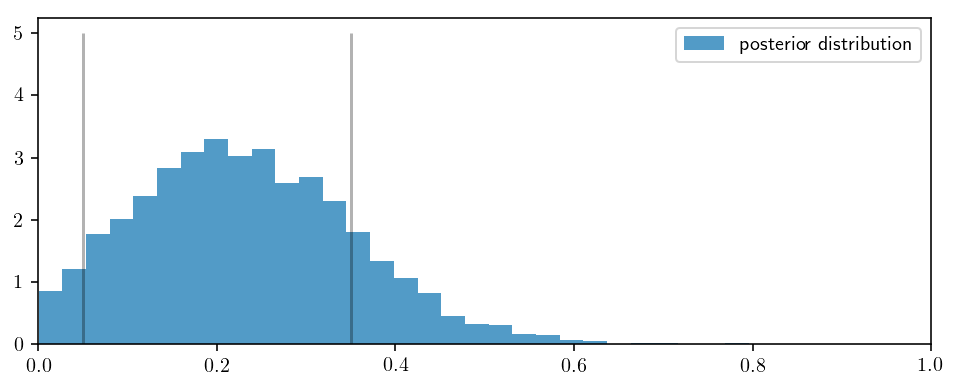

In [3]:
def visualize_freq_cheating(trace):
    figsize(8, 3)
    p_trace = trace['freq_cheating']
    plt.hist(p_trace, histtype='stepfilled', normed=True, alpha=0.85, bins=30, 
             label='posterior distribution', color='#348ABD')
    plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
    plt.xlim(0, 1)
    plt.legend()
    plt.show()

visualize_freq_cheating(trace)

**Alternative model**

We could easily calculate the probability of getting *yes response*: $p_X = 0.5 * p + 0.5 * 0.5 = 0.5p + 0.25$.

So our model is now simpler:
- $X ~ Ber(p_X) = Ber(0.5p + 0.25)$

In [4]:
with pm.Model() as model:
    p = pm.Uniform('freq_cheating', 0, 1) # Unknown
    p_skewed = pm.Deterministic('p_skewed', 0.5*p + 0.25)

X = 35 # observed data
with model:
    yes_responses = pm.Binomial('num_cheaters', N, p_skewed, observed=X)

with model:
    step = pm.Metropolis()
    trace_2 = pm.sample(40000, step=step)

100%|██████████| 40500/40500 [00:04<00:00, 9189.10it/s]


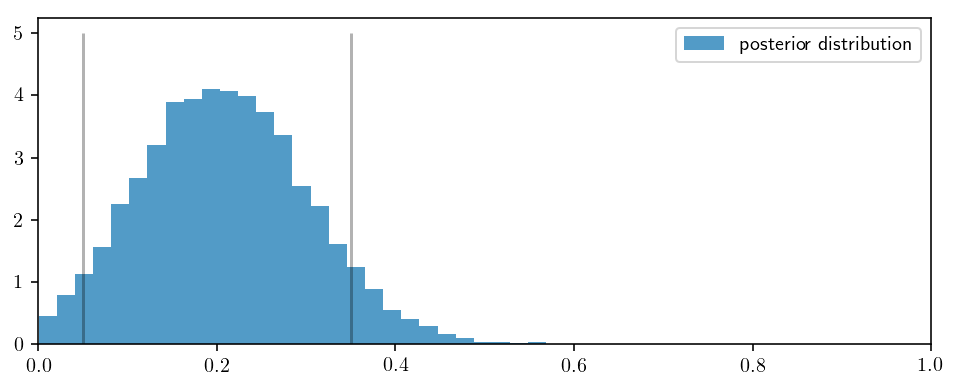

In [5]:
visualize_freq_cheating(trace_2)

Note: *Results from the two models above are the same to a certain point. Though it takes a huge amount of time to sample the former (17mins as compared to 4s)*